# Baseline Model

## Table of Contents
1. [Model Choice](#model-choice)
2. [Feature Selection](#feature-selection)
3. [Implementation](#implementation)
4. [Evaluation](#evaluation)


## Model Choice

As a baseline modell a simple regression modell is mostly a good starting point. A appropriate modell for a classification problem is logistic regression, which I will use in the following.

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, mean_squared_error
import warnings

warnings.filterwarnings('ignore')


## Implementation

Logistic regression:


In [14]:
import pandas as pd
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
import copy
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, classification_report
import numpy as np 
# Load the dataset
df = pd.read_csv('/home/tomruge/Schreibtisch/UNI/Semester_7/machine_learning_with_tensorflow/archive_physical_activity.csv', engine='pyarrow')
# Drop all rows with NaN values
df.dropna(inplace=True)
# undersampling

def perform_random_undersampling(df, target_column, minority_class = 'rope jumping'):
    minority_class_len = len(df[df[target_column] == minority_class])
    indices = []
    for i in np.unique(df[target_column]):
        indices.extend(np.random.choice(df[df[target_column] == i].index, minority_class_len, replace=False))
    indices_sort = np.sort(indices)
    return df.loc[indices_sort]




df_undersample = perform_random_undersampling(df, 'activityID')
label_encoder = LabelEncoder()
df_undersample['activityID'] = label_encoder.fit_transform(df_undersample['activityID'])

df['activityID'] = label_encoder.fit_transform(df['activityID'])

average_accuracy_list = []
for k in range(5):
    models = []
    X_tests = []
    y_tests = []
    for i in range(1,9):  # Assuming you have 10 unique PeopleId
        print('peopleID_mask: ', i, ' of 8')
        # Mask for train and test split
        work_df = copy.deepcopy(df_undersample)  # Use deepcopy to avoid unintended mutation
        
        mask = (work_df['PeopleId'] != i)

        # Extract training data
        y_train = work_df['activityID'][mask]
        X_train = work_df.drop(['activityID', 'PeopleId'], axis=1, inplace = False)[mask]

        mask = (df['PeopleId'] == i)
        # Extract testing data
        y_test = work_df['activityID'][mask]
        X_test = work_df.drop(['activityID', 'PeopleId'], axis=1, inplace = False)[mask]

        # Standardize the features
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)

        # Create and train the logistic regression model
        model = LogisticRegression(multi_class='multinomial', max_iter=100000)
        model.fit(X_train_scaled, y_train)
        
        models.append(copy.deepcopy(model))
        X_tests.append(copy.deepcopy(X_test_scaled))
        y_tests.append(copy.deepcopy(y_test))
        
    y_pred_labels_list = []
    accuracy_list = []

    # print mapping
    print("Mapping:")
    for label, mapped_label in zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)):
        print(f"{label} -> {mapped_label}")

    # evaluate
    for i in range(8):
        print("Test_PeopleID_mask:", i+1)
        
        # Make predictions on the test set using the i-th model
        y_pred = models[i].predict(X_tests[i])

        # Evaluate the model
        accuracy = accuracy_score(y_tests[i], y_pred)
        print(f'Accuracy: {accuracy:.2f}')

        # Display classification report
        print(classification_report(y_tests[i], y_pred))
        
        y_pred_labels_list.append(y_pred)

        # Check if all entries in y_tests and y_pred_labels_list are the same
        unique_values_y_tests = set(y_tests[i])
        unique_values_y_pred = set(y_pred_labels_list[i])
        
        # Check if all values match
        match_all = np.array_equal(y_tests[i], y_pred_labels_list[i])
        accuracy_list.append(accuracy)
        print("-" * 40)

    print(f"Average accuracy: {np.mean(accuracy_list):.2f}")
    print(f"Standard deviation: {np.std(accuracy_list):.2f}")
    average_accuracy_list.append(np.mean(accuracy_list))

print(f"Average accuracy over all runs: {np.mean(average_accuracy_list):.2f}")

peopleID_mask:  1  of 8
peopleID_mask:  2  of 8
peopleID_mask:  3  of 8
peopleID_mask:  4  of 8
peopleID_mask:  5  of 8
peopleID_mask:  6  of 8
peopleID_mask:  7  of 8
peopleID_mask:  8  of 8
Mapping:
Nordic walking -> 0
ascending stairs -> 1
cycling -> 2
descending stairs -> 3
ironing -> 4
lying -> 5
rope jumping -> 6
running -> 7
sitting -> 8
standing -> 9
transient activities -> 10
vacuum cleaning -> 11
walking -> 12
Test_PeopleID_mask: 1
Accuracy: 0.44
              precision    recall  f1-score   support

           0       0.54      0.59      0.57      4650
           1       0.38      0.56      0.46      5764
           2       0.94      0.94      0.94      6200
           3       0.62      0.44      0.51      6141
           4       0.30      1.00      0.46      4241
           5       0.85      0.78      0.81      6045
           6       0.18      0.09      0.12     12912
           7       0.26      0.66      0.37      9387
           8       0.00      0.00      0.00      548

## Evaluation

My metrics will be: $$ Accuracy = \frac{Number\ of\ Correct\ Predictions}{Total\ Number\ of\ Predictions}$$


Confusion matrix:

Test_PeopleID_mask: 1


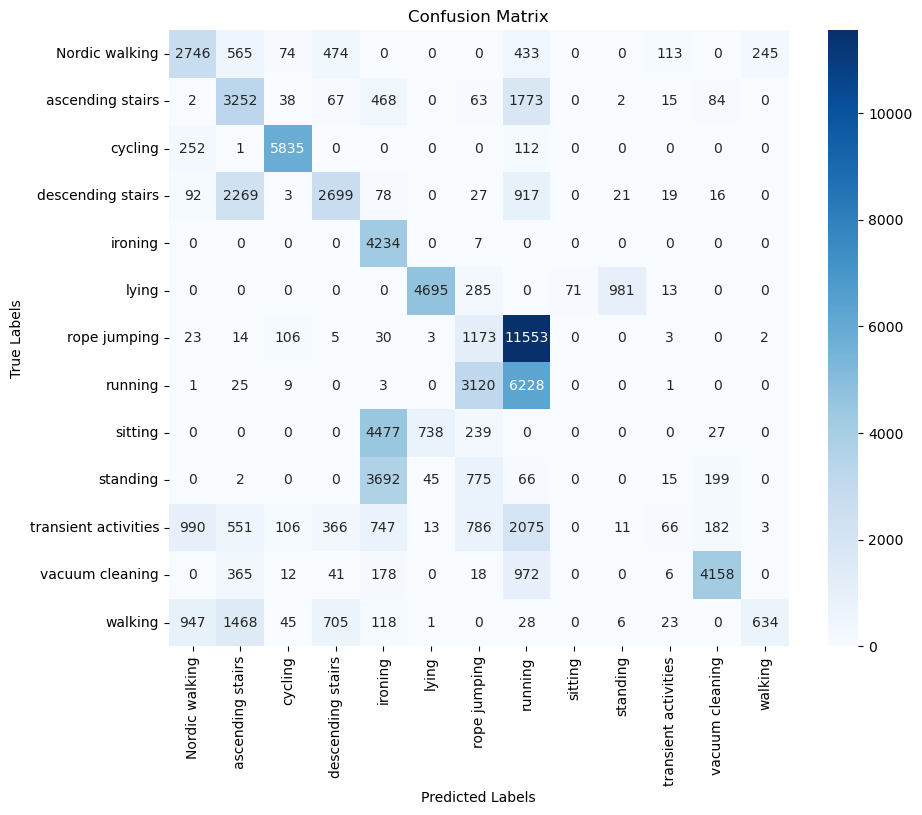

Test_PeopleID_mask: 2


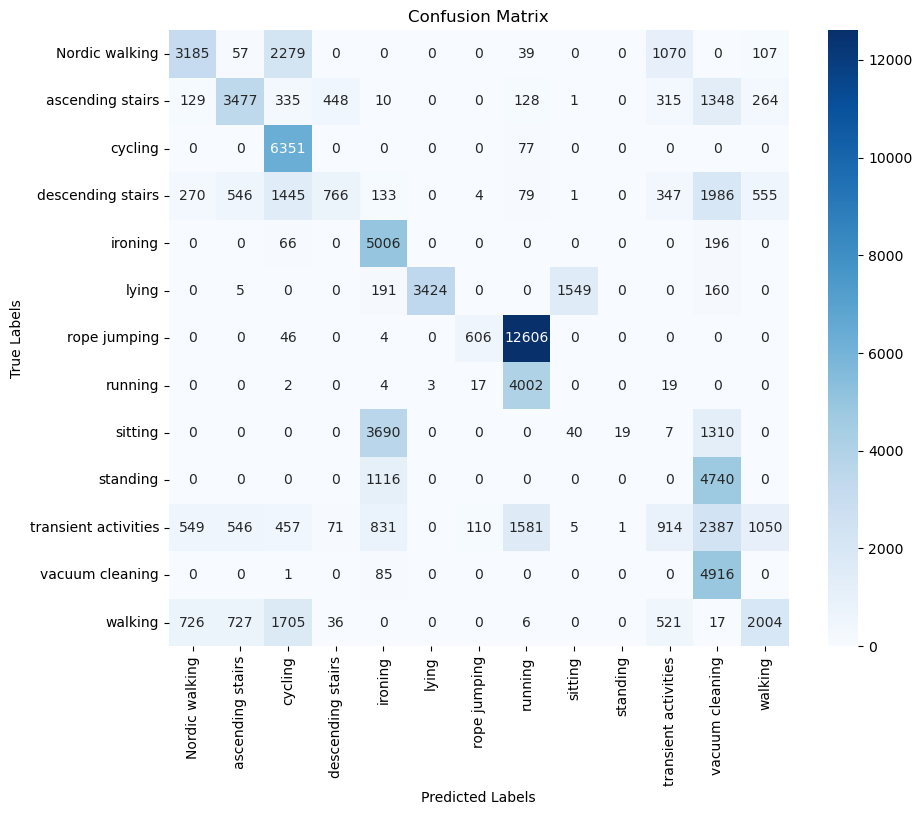

Test_PeopleID_mask: 3


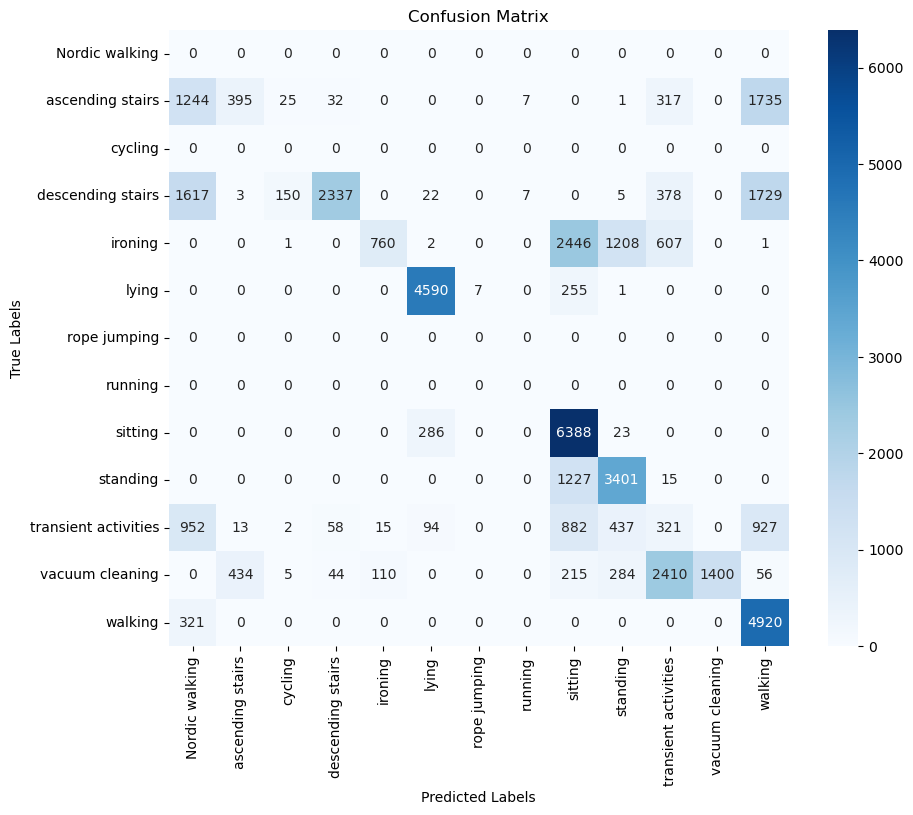

Test_PeopleID_mask: 4


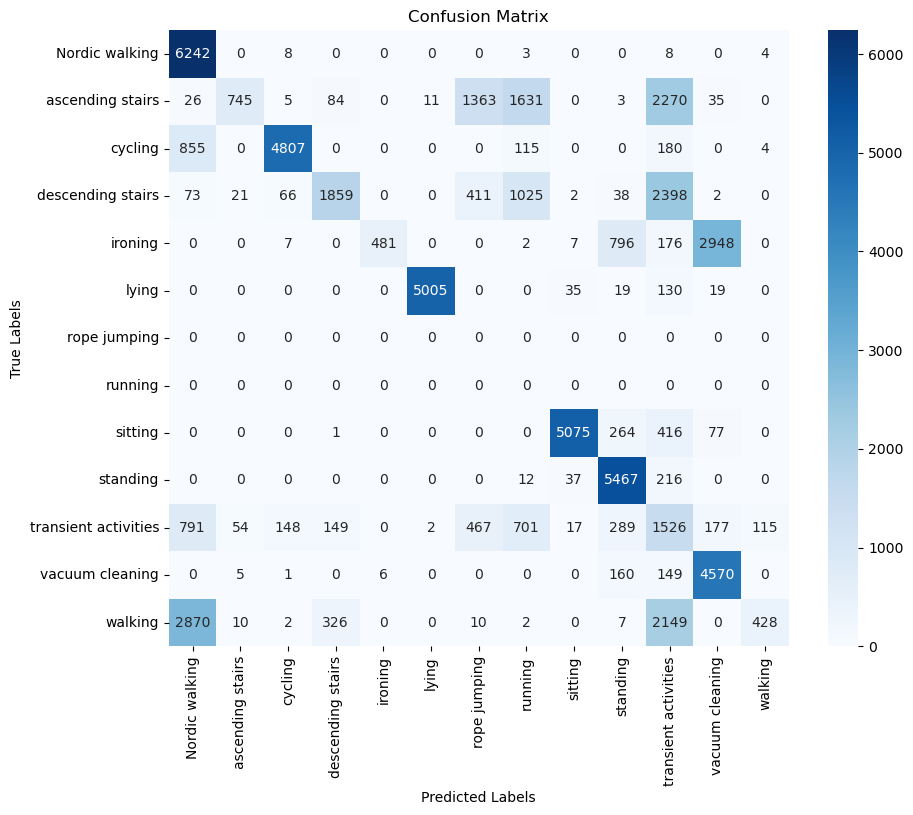

Test_PeopleID_mask: 5


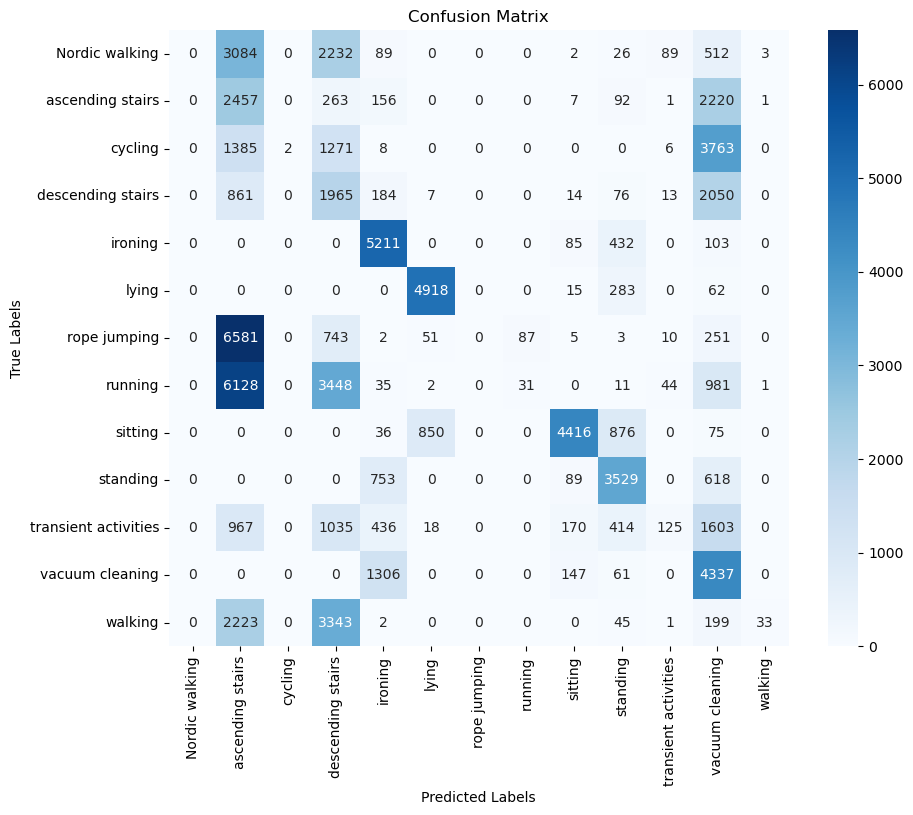

Test_PeopleID_mask: 6


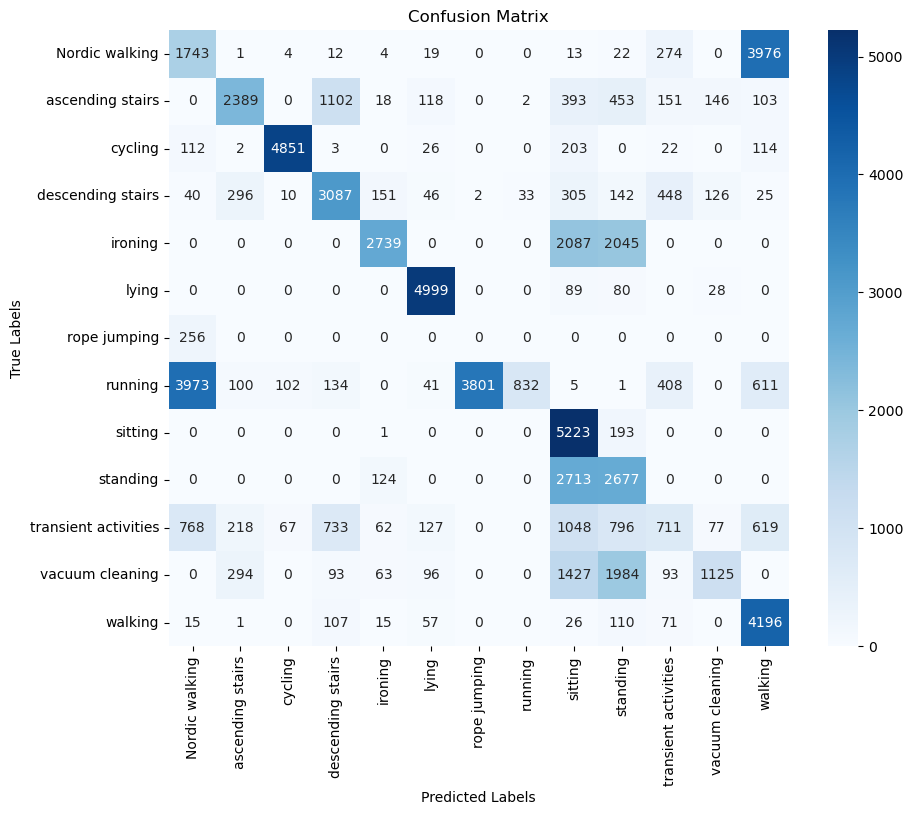

Test_PeopleID_mask: 7


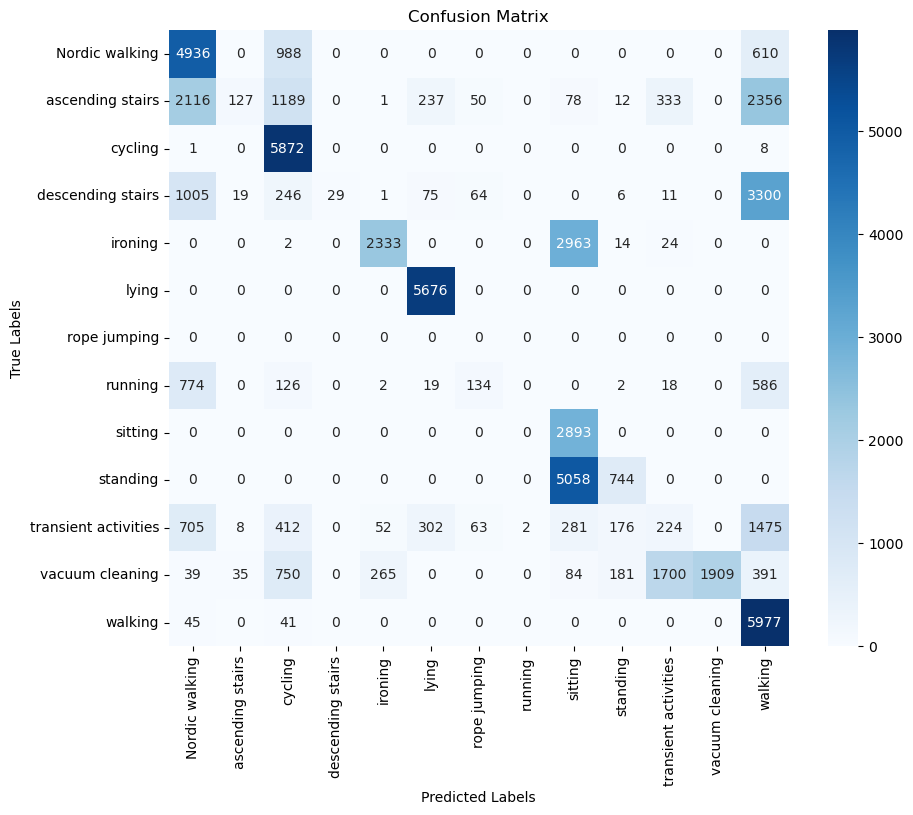

Test_PeopleID_mask: 8


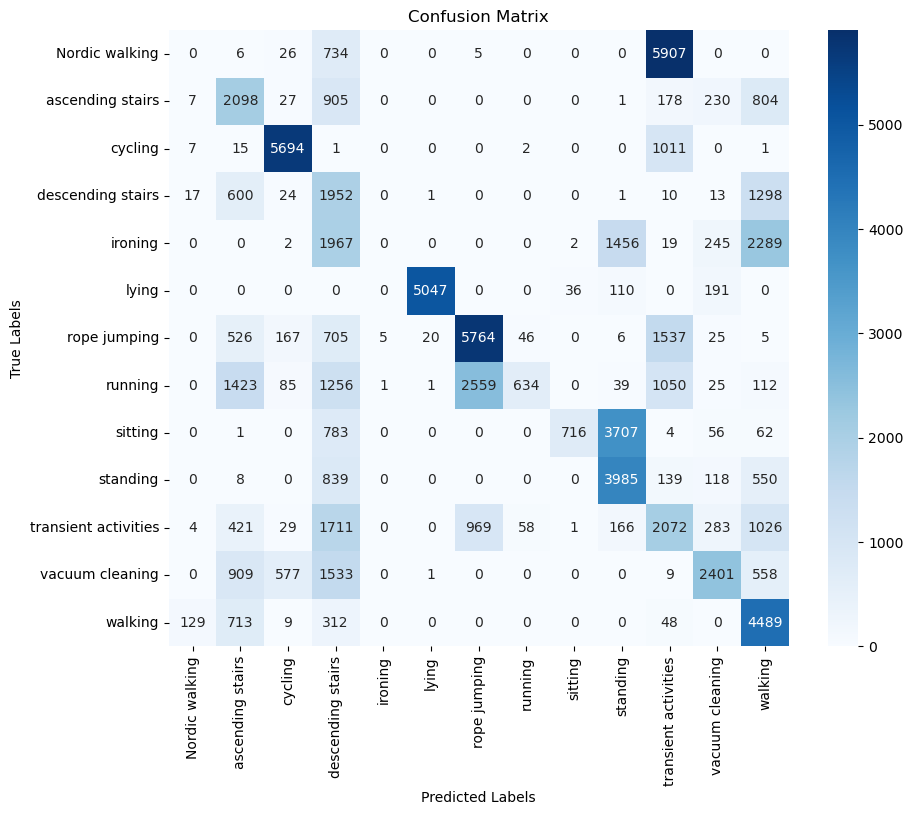

In [16]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

for i in range(8):
    print("Test_PeopleID_mask:", i+1)
    
    # Calculate the confusion matrix
    conf_matrix = confusion_matrix(y_tests[i], y_pred_labels_list[i])

    # Plot the confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", 
                xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
    
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()


As expected the modell is confused by transient activities, since they are not well defined and have a big deviation within itself. Also activities which can be seen related like sitting and lying got confused very often. But for a first modell not that bad.